In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [2]:
# Numpy array of blogs
train_data = np.load("splits/split_0.npy", allow_pickle=True)

train_data = pd.DataFrame(data=train_data, columns=['ID', 'BLOG'])
train_data

,ID,BLOG
0,2627816,\n \n \n Made my Windows look li...
1,3238696,\n Well lets see...on Thursday we played...
2,1853281,"\n okay, so i got another paper assignm..."
3,2841530,Woke up at 2 feeling crappy as hell. All be...
4,3222762,\n Yeah actually the post yesterday I di...
...,...,...
7269,1088782,\n\n here is a link to the playlist ...
7270,2643351,\n\n \n If you drained Boca Res...
7271,3140588,"\n\t \n well it's finally sunday night, t..."
7272,1633002,going to try to post a Master Shake Quote Gene...


In [3]:
train_data['BLOG'] = train_data['BLOG'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
train_data['BLOG'] = ' ' + train_data['BLOG'].str.lower() + ' '
vocabulary = list(set(train_data['BLOG'].str.split().sum()))

In [4]:
author_uses_word = pd.DataFrame(0, index=train_data.index, columns=vocabulary)
author_uses_word = author_uses_word.apply(lambda series: train_data['BLOG'].str.contains(r' %s ' % series.name))
author_uses_word = author_uses_word.loc[:, author_uses_word.sum(axis=0) > 5]
author_uses_word = pd.concat([train_data.drop(columns=['BLOG']), author_uses_word], axis=1)
author_uses_word

,ID,certain,yah,classroom,annie,chairs,accomplish,compassion,rates,props,...,builds,had,wud,piled,huge,painfully,communication,kids,gmail,congregation
0,2627816,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3238696,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,1853281,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2841530,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3222762,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,1088782,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7270,2643351,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
7271,3140588,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
7272,1633002,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
def information_gain(contains_word):
    parent_entropy = entropy(np.logical_or(contains_word, True))
    
    proportion_true = split_proportion(contains_word)
    true_entropy = entropy(contains_word)
    
    proportion_false = split_proportion(np.logical_not(contains_word))
    false_entropy = entropy(np.logical_not(contains_word))
    
    return parent_entropy - (proportion_true * true_entropy + proportion_false * false_entropy)

def split_proportion(contains_word):
    return contains_word.drop(columns=['ID']).sum() / len(contains_word)

def entropy(contains_word):
    np.seterr('ignore')
    
    authors = contains_word.groupby('ID').aggregate(np.sum)
    author_proportion = authors / authors.sum()
    author_proportion = author_proportion.replace([-np.nan, np.nan], 1.)
    
    term = -1. * author_proportion * np.log2(author_proportion)
    term = term.replace([-np.nan, np.nan], 0.)
    
    np.seterr('warn')
    
    return term.sum()

word_information_gain = information_gain(author_uses_word)
best_words = np.array(word_information_gain.sort_values(ascending=False)[:500].index, dtype=str)

In [6]:
word_information_gain.sort_values(ascending=False)[:500]

actuali        9.528663
m8s            9.528663
ngelastiger    9.528663
soz            9.528663
ttul           9.528663
                 ...   
endorsed       9.527080
maniac         9.527080
danielle       9.527080
80s            9.527080
adjacent       9.527080
Length: 500, dtype: float64

In [44]:
best_words_sample = np.random.choice(best_words, len(best_words))[:50]
word_weights = {word: word_information_gain[word] for word in best_words_sample}

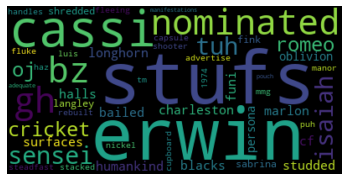

In [45]:
wordcloud = WordCloud().generate_from_frequencies(word_weights)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
wordcloud.to_file('best_words_3.png')